In [1]:
import sys
sys.path.append("../")


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from openpyxl import load_workbook

from linearmodels import PanelOLS


from library import print_statistics

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/panel/data.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import (Categorical, DataFrame, Index, MultiIndex, Panel, Series,


In [2]:
def coef_with_stars(coef, pvalue):
    coef = round(coef, 2)
    if pvalue >.05:
        coef = str(coef)
    if pvalue <= .05:
        coef = str(coef) + '*'
    if pvalue <= .01:
        coef = coef + '*'
    if pvalue <= .001:
        coef = coef + '*'
    return(coef)
test = coef_with_stars(9.1568, .005)
test

'9.16**'

In [3]:
def format_se(se):
    if se < .005:
        se = '(0.00)'
    else:
        se = '(' + str(round(se, 2)) + ')'
    return se
test = format_se(.0053)
test

'(0.01)'

In [4]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/Who Needs Rules/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid.csv'),
                  sep=",", low_memory= False)
#load(data)
print(data[data.doi == True].district.nunique())
data = data[data.doi == True]

data.sample()

data['doi_year'] = np.where((data.doi_year == 2015), np.nan, data.doi_year) #drop first implementer (one district)


822


In [5]:
data.doi_year.value_counts()

2017.0    33831
2018.0     7586
2016.0     7422
2019.0     1633
Name: doi_year, dtype: int64

# Create trend and nonparametric variables

## Phase-in Effect - yearpost

In [6]:
data['yearpost'] = np.where(data.year > data.doi_year, data.year - data.doi_year, 0)
data[['year', 'doi_year', 'yearpost']].sample(10)

,year,doi_year,yearpost
12161,2013,2017.0,0.0
58768,2018,NaN,0.0
41887,2016,2017.0,0.0
46335,2017,2017.0,0.0
57112,2018,2017.0,1.0
41191,2016,2017.0,0.0
39880,2016,2017.0,0.0
66407,2019,2017.0,2.0
12413,2013,2017.0,0.0
58257,2018,2017.0,1.0


In [7]:
data.yearpost.value_counts()

0.0    38694
1.0     6129
2.0     5190
3.0      938
Name: yearpost, dtype: int64

## Pretrends - yearpre

In [8]:
data['yearpre'] = np.where(data.year <= data.doi_year, data.year - data.doi_year, 0)
data[['year', 'doi_year', 'yearpost', 'yearpre']].sample(5)

,year,doi_year,yearpost,yearpre
40541,2016,2016.0,0.0,0.0
20247,2014,2016.0,0.0,-2.0
52381,2018,2019.0,0.0,-1.0
34022,2015,2017.0,0.0,-2.0
37901,2016,2017.0,0.0,-1.0


In [9]:
data.yearpre.value_counts()

 0.0    19082
-1.0     6329
-2.0     6293
-3.0     6275
-4.0     6263
-5.0     5356
-6.0     1152
-7.0      201
Name: yearpre, dtype: int64

## Non-parametric fixed effects for years pre and post - pre# and post#

In [10]:
data['pre5'] = np.where(data.yearpre <= -5, 1, 0)
data['pre4'] = np.where(data.yearpre == -4, 1, 0)
data['pre3'] = np.where(data.yearpre == -3, 1, 0)
data['pre2'] = np.where(data.yearpre == -2, 1, 0)
data['pre1'] = np.where(data.yearpre == -1, 1, 0)
data['pre0'] = np.where(data.yearpre == 0, 1, 0)
data['post1'] = np.where(data.yearpost == 1, 1, 0)
data['post2'] = np.where(data.yearpost == 2, 1, 0)
data['post3'] = np.where(data.yearpost == 3, 1, 0)


In [11]:
#convert year to datetime
df = data.reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
#add column year to index
df = data.set_index(['year', 'campus'])
#swap indexes
df.index = df.index.swaplevel(0,1)
df[['district', 'doi_year','treatpost']].sample(5)

,,district,doi_year,treatpost
campus,year,,,
11901101,2012,11901,2017.0,False
236902002,2015,236902,2016.0,False
188901128,2013,188901,2017.0,False
61902131,2019,61902,2017.0,True
234909101,2016,234909,2017.0,False


# Specifications

In [12]:
# Get table ready
#file = table_path + 'tableX_gdid_and_event.xlsx'
#wb = load_workbook(file)
#ws = wb.active

In [13]:
list(df.columns)

['Unnamed: 0',
 'campname',
 'campischarter',
 'district',
 'distname',
 'distischarter',
 'rating_academic',
 'rating_financial',
 'rating_academic_c',
 'type',
 'type_description',
 'cntyname',
 'students_amind_num',
 'students_asian_num',
 'students_black_num',
 'students_cte_num',
 'students_ell_num',
 'students_frpl_num',
 'students_hisp_num',
 'students_num',
 'students_num_d',
 'students_paci_num',
 'students_sped_num',
 'students_tworaces_num',
 'students_white_num',
 'teachers_badegree_num',
 'teachers_exp_ave',
 'teachers_msdegree_num',
 'teachers_new_num',
 'teachers_nodegree_num',
 'teachers_num',
 'teachers_phddegree_num',
 'teachers_tenure_ave',
 'teachers_turnover_ratio_d',
 'alg_avescore',
 'bio_avescore',
 'eng1_avescore',
 'eng2_avescore',
 'm_3rd_avescore',
 'm_4th_avescore',
 'm_5th_avescore',
 'm_6th_avescore',
 'm_7th_avescore',
 'm_8th_avescore',
 'r_3rd_avescore',
 'r_4th_avescore',
 'r_5th_avescore',
 'r_6th_avescore',
 'r_7th_avescore',
 'r_8th_avescore',
 's_

## Simple GDID

In [14]:
mod = PanelOLS.from_formula('certification ~ + 1 + treatpost + students_hisp + students_num + TimeEffects + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
#ws.cell(row= 3, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
#ws.cell(row= 4, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:          certification   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):             -0.0370
No. Observations:               36968   R-squared (Within):              -0.0020
Date:                Tue, Dec 17 2019   R-squared (Overall):             -0.0165
Time:                        17:30:23   Log-likelihood                 9.576e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.3739
Entities:                        6486   P-value                           0.0044
Avg Obs:                       5.6997   Distribution:                 F(3,30474)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             4.0660
                            

## GDID with Trends

In [15]:
mod = PanelOLS.from_formula('certification ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + TimeEffects + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
#intercept = res.params['Intercept']
jump = res.params['treatpost[T.True]']
preslope = res.params['yearpre']
postslope = res.params['yearpost']
#ws.cell(row= 6, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
#ws.cell(row= 7, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])
#ws.cell(row= 8, column= 2).value = coef_with_stars(res.params['yearpost'], res.pvalues['treatpost[T.True]'])
#ws.cell(row= 9, column= 2).value = format_se(res.std_errors['yearpost'])
#ws.cell(row= 10, column= 2).value = coef_with_stars(res.params['yearpre'], res.pvalues['treatpost[T.True]'])
#ws.cell(row= 11, column= 2).value = format_se(res.std_errors['yearpre'])
#wb.save(file)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:          certification   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):             -0.0356
No. Observations:               36968   R-squared (Within):               0.0082
Date:                Tue, Dec 17 2019   R-squared (Overall):             -0.0090
Time:                        17:30:33   Log-likelihood                 9.576e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.8253
Entities:                        6486   P-value                           0.0148
Avg Obs:                       5.6997   Distribution:                 F(5,30472)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             2.7882
                            

In [16]:
mod = PanelOLS.from_formula('certification ~ + 1 + pre5 + pre4 + pre3 + pre2 + pre1 + post1 + post2 + post3 + students_hisp + students_num + TimeEffects + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
nonparametric = []
for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'pre0', 'post1', 'post2', 'post3']:
    nonpar = 0
    if coef != 'pre0':
        nonpar = res.params[coef]
    nonparametric.append(nonpar)
print(nonparametric)
row = 3
#for coef in ['post3', 'post2', 'post1', 'pre1', 'pre2', 'pre3', 'pre4', 'pre5']:
#    ws.cell(row= row, column= 4).value = coef_with_stars(res.params[coef], res.pvalues[coef])
#    row = row + 1
#    ws.cell(row= row, column= 4).value = format_se(res.std_errors[coef])  
#    row = row + 1
#wb.save(file)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


ValueError: exog does not have full column rank.

# Create graph (look up how to use predicted values)


In [17]:
years = [-5, -4, -3, -2, -1, 0, 1, 2, 3]
parametric = []
for year in years:
    par = 0
    if year < 0 :
        par = (year * preslope)
    if year > 0 :
        par = jump + (year * postslope)
    parametric.append(par)
parametric   

[-0.0013859035862386724,
 -0.001108722868990938,
 -0.0008315421517432035,
 -0.000554361434495469,
 -0.0002771807172477345,
 0,
 8.33640376296965e-05,
 -0.0003677217885540759,
 -0.0008188076147378483]

In [18]:
nonparametric

NameError: name 'nonparametric' is not defined

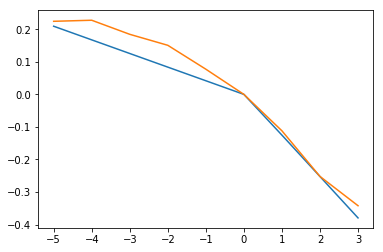

In [23]:
plt.plot(years, parametric)
plt.plot(years, nonparametric)